<a href="https://colab.research.google.com/github/SewoongPark/SeSac_study_repo/blob/main/study_00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **TIL**
### 프로젝트
* 프로젝트(포트폴리오)에서 보여줘야 될 것은 여러가지를 알고 있다는 것
* 좋은 성능을 강조하기 보다 최대한 많은 기술을 담아야 함
* 여러 모델들의 특징을 간략하게 설명한 뒤에 본인의 데이터셋으로 학습을 한 결과를 보여주고, baseline 모델 선택에 대한 이유를 제시해야 함

**keras tuner 사용해보기**
> <a>https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=ko</a>

* 전이학습에서의 fine tunning
  * 학습된 모델의 레이어와 weight를 어디까지 사용할지를 지정해주는 것
  
> 전이 학습(Transfer Learning)에서 fine-tuning은 이미 학습된 모델의 일부 레이어나 가중치를 새로운 작업에 맞게 조정하는 과정을 말합니다.<br> 기존에 풀려고 했던 작업과 유사한 작업을 수행하는 새로운 작업에 대해 기존 모델의 일부를 재사용하여 성능을 향상시키는 기법입니다.

* Fine-tuning은 일반적으로 다음과 같은 단계로 이루어집니다:

  * Pre-trained Model 선택: 특정 작업에 가장 적합한 사전 학습된 모델을 선택합니다. 이는 대규모 이미지 데이터셋 (예: ImageNet)에서 학습된 VGG, ResNet, 또는 텍스트 데이터에서 학습된 BERT 등과 같은 모델일 수 있습니다.
  * 모델의 일부 레이어 고정: 주로 모델의 초기 레이어들을 고정하고, 특정 레이어 이후의 레이어들을 새로운 데이터셋에 맞게 fine-tuning합니다. 고정된 레이어들은 이전에 학습된 특징 추출기로서의 역할을 수행하며, 새로운 데이터셋에 맞게 그대로 사용됩니다.
  * 학습률 조정: 새로운 데이터셋에서의 fine-tuning을 위해 학습률(learning rate)을 조정합니다. 보통 이전 레이어들은 낮은 학습률로 설정하고, fine-tuning할 레이어들은 상대적으로 높은 학습률을 사용합니다.
  * 새로운 데이터셋 학습: 주어진 새로운 작업에 대해 fine-tuning을 진행합니다. 이는 새로운 데이터셋에 대해 모델을 재조정하는 과정으로, 모델이 새로운 작업에 더 잘 맞도록 하는 것입니다.
  * 성능 평가: Fine-tuning된 모델을 평가하여 새로운 작업에 대한 성능을 평가합니다. 이는 정확도, 정밀도, 재현율 등의 지표를 사용하여 이루어질 수 있습니다.

**최대한 많은 기술을 사용했다는 것을 보여주기:** <br>
  * depthwise separable convolution, xception, inception, VGG, ResNet50 모델 등 사용해보기
* 참고자료: <a>https://underflow101.tistory.com/42

### 평가: 전이학습을 이용하여서 본인만의 분류학습 모델을 제작 및 파인튜닝 과정을 pt로 정리

## 1. 데이터셋 준비

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pwd

'/content'

In [3]:
!unzip -qq "/content/drive/MyDrive/archive.zip"

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

import numpy as np
import matplotlib.pyplot as plt

import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [ ]:
!apt-get install tree
#clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

In [2]:
import os
import shutil

IMG_PATH = '/content/brain_tumor_dataset/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [6]:
import matplotlib.pyplot as plt

# train_generator에서 이미지 배치를 가져옵니다.
images, labels = train_generator.next()

# 가져온 이미지 배치를 시각화합니다.
plt.figure(figsize=(10, 10))
for i in range(len(images)):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title('Label: {}'.format(labels[i]))
    plt.axis('off')
plt.show()


NameError: name 'train_generator' is not defined

In [3]:
import tqdm as tq
import cv2
import os

def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tq.tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.asarray(X, dtype = "object") #dtype = object로 지정해주어야 함
    y = np.array(y)

    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


193 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00,  8.15it/s]


10 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

50 images loaded from VAL/ directory.


In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((193,), (10,), (193,), (10,))

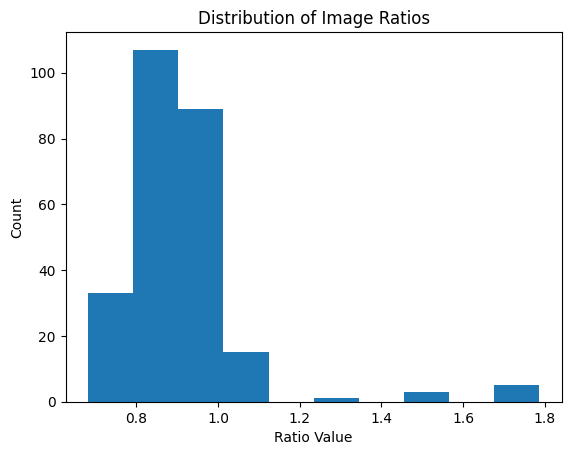

In [4]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])

plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()


In [5]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [6]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

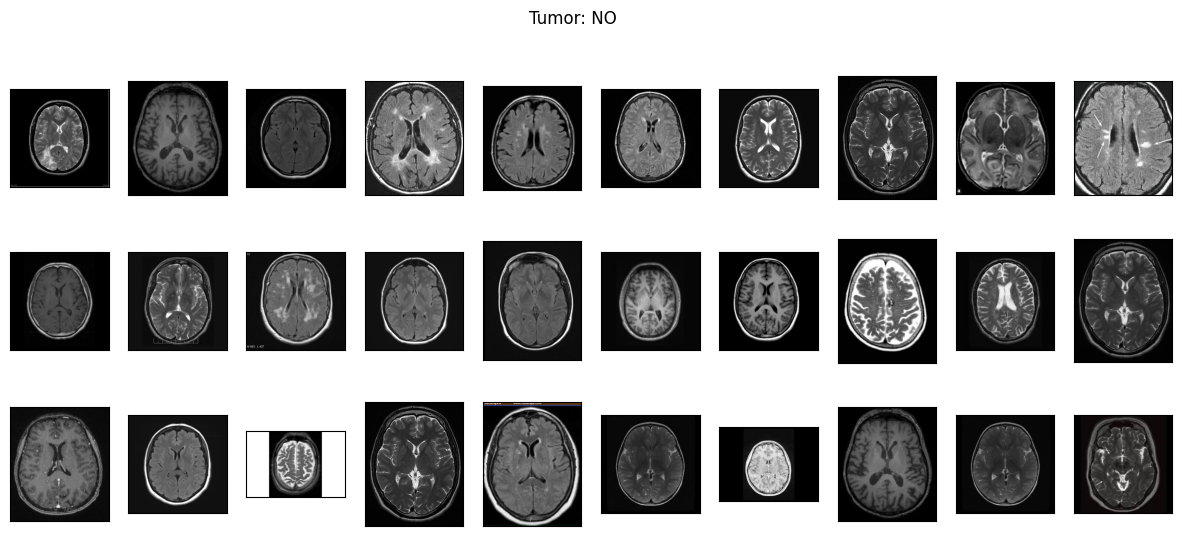

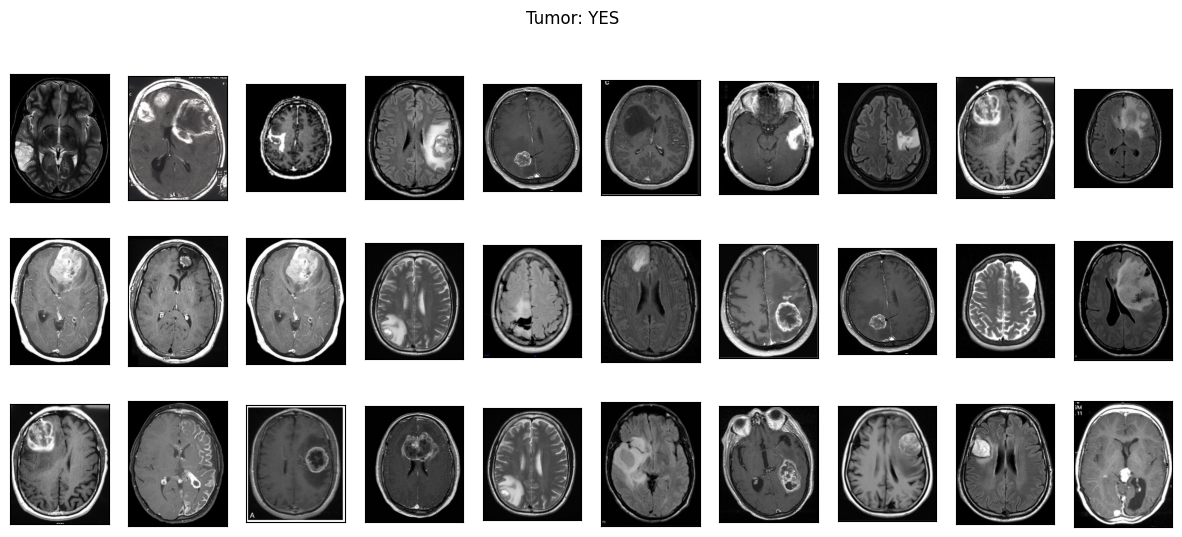

In [7]:
plot_samples(X_train, y_train, labels, 30)

In [8]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        normalized_img = preprocess_input(img)
        set_new.append(normalized_img)
    return np.array(set_new)

In [9]:
X_train_prep = preprocess_imgs(set_name=X_train, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val, img_size=IMG_SIZE)

X_train_prep /= 255.0
X_test_prep /= 255.0
X_val_prep /= 255.0

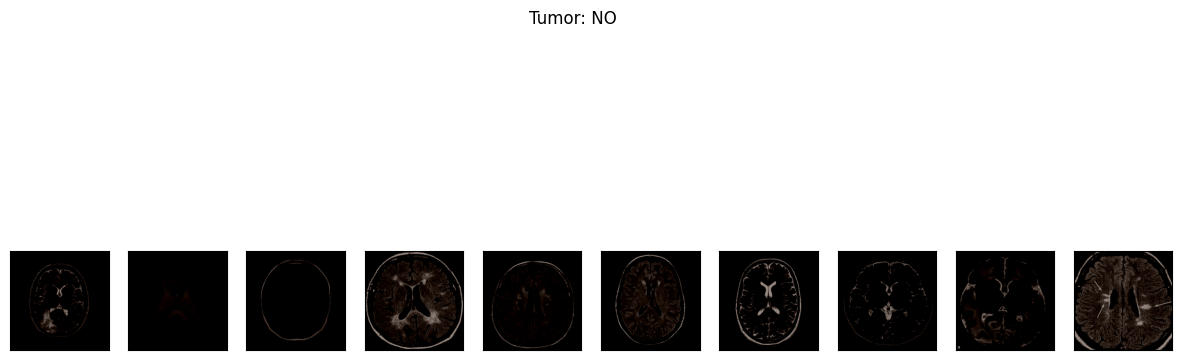

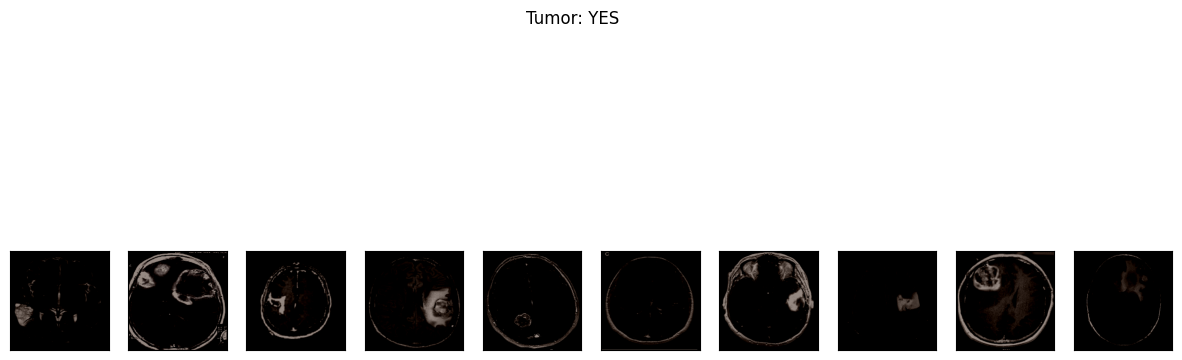

In [10]:
 plot_samples(X_train_prep , y_train, labels, 10)

### **Image Crop 수행**

In [11]:
def crop_and_resize_imgs(set_name, img_size, add_pixels_value=0):
    """
    Finds the extreme points on the image, crops and resizes them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        cropped_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        resized_img = cv2.resize(cropped_img, img_size, interpolation=cv2.INTER_AREA)
        set_new.append(resized_img)

    return np.array(set_new)

# 이미지를 자르고 크기를 조정하여 모든 이미지가 동일한 모양을 갖도록합니다.
X_train_crop = crop_and_resize_imgs(set_name=X_train, img_size=IMG_SIZE)
X_val_crop = crop_and_resize_imgs(set_name=X_val, img_size=IMG_SIZE)
X_test_crop = crop_and_resize_imgs(set_name=X_test, img_size=IMG_SIZE)


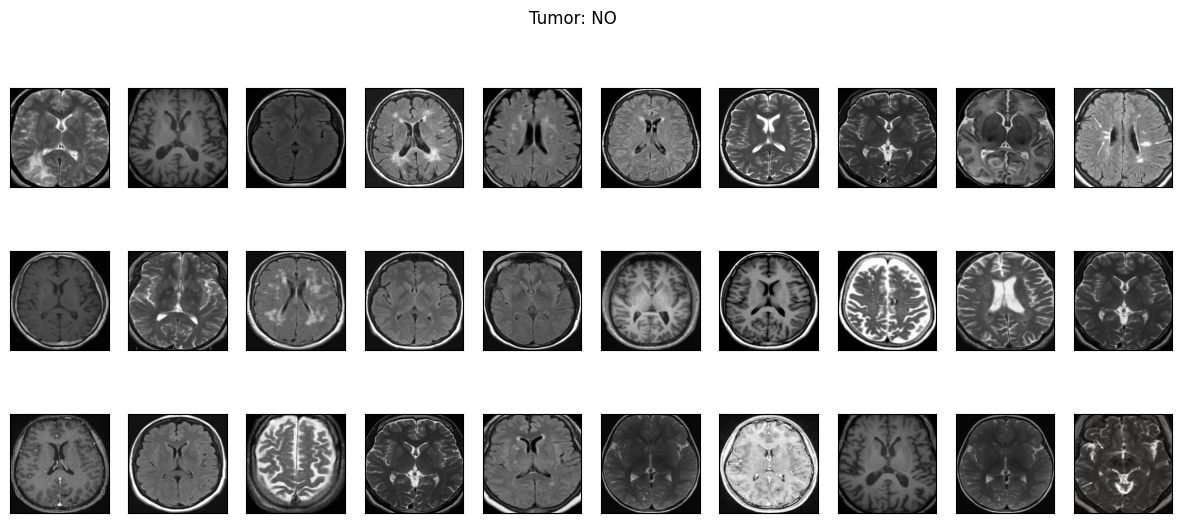

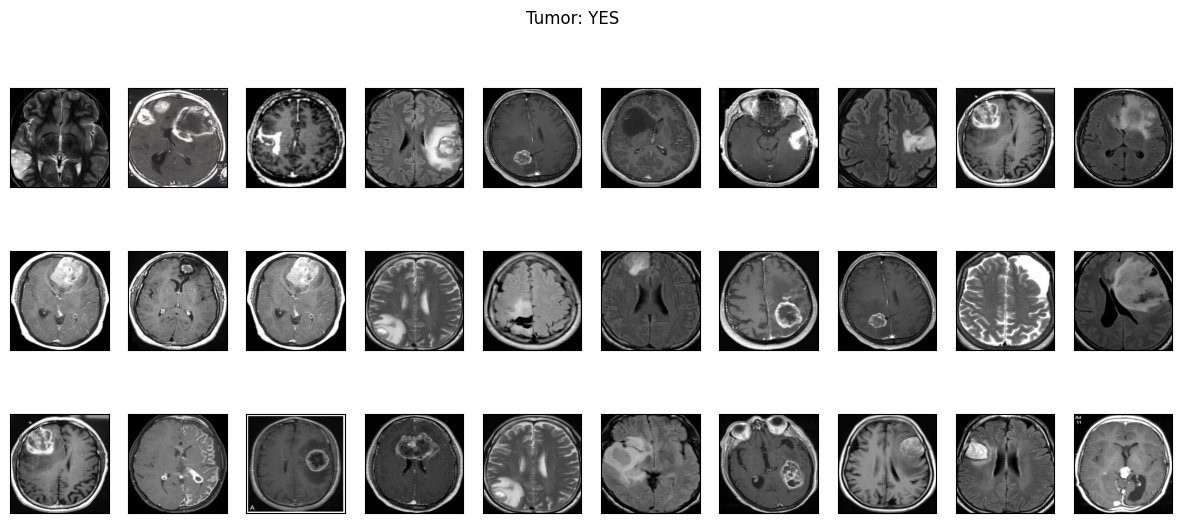

In [12]:
plot_samples(X_train_crop, y_train, labels, 30)

In [13]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [14]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

mkdir: cannot create directory ‘TRAIN_CROP’: File exists
mkdir: cannot create directory ‘TEST_CROP’: File exists
mkdir: cannot create directory ‘VAL_CROP’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/YES’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/NO’: File exists
mkdir: cannot create directory ‘TEST_CROP/YES’: File exists
mkdir: cannot create directory ‘TEST_CROP/NO’: File exists
mkdir: cannot create directory ‘VAL_CROP/YES’: File exists
mkdir: cannot create directory ‘VAL_CROP/NO’: File exists


In [16]:
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

# os.mkdir('preview')
x = X_train_crop[0]
x = x.reshape((1,) + x.shape)

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

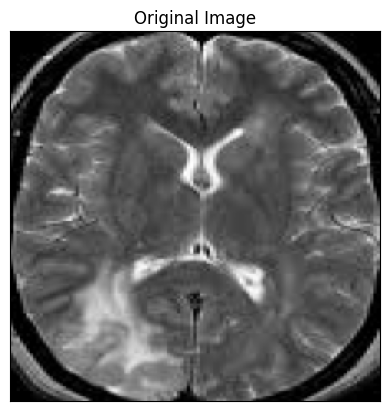

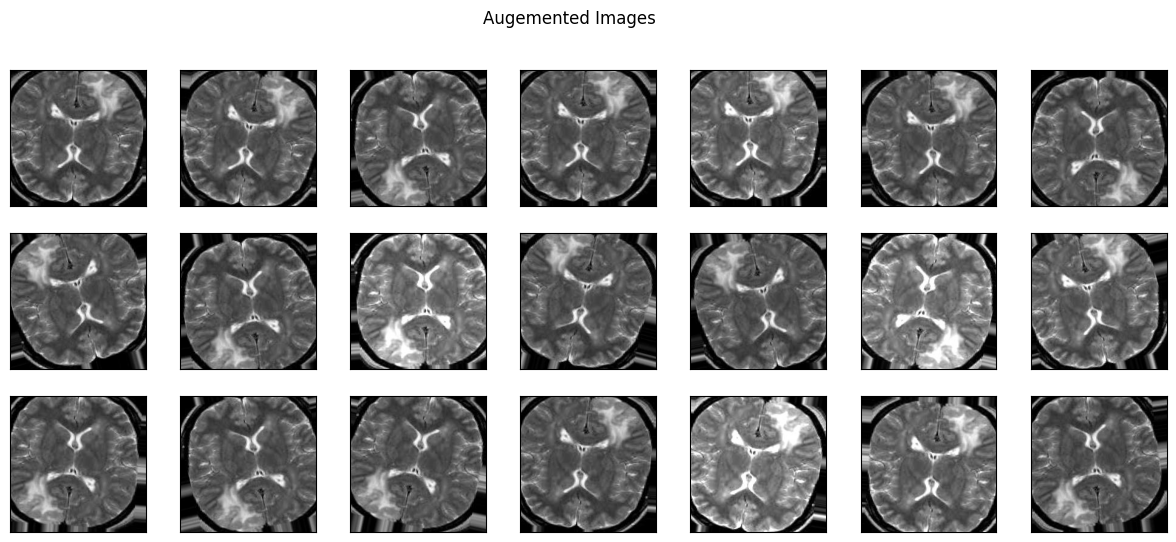

In [17]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [18]:
!rm -rf preview/

In [46]:
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

In [57]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

In [70]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)



validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


**클래스 별 할당된 데이터 수 확인**

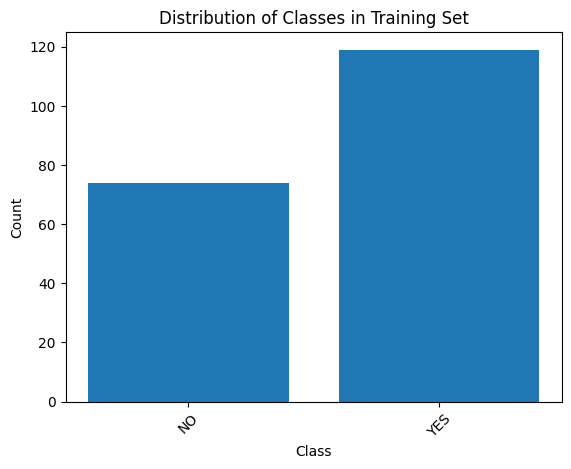

In [71]:
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

class_counts = train_generator.classes
unique, counts = np.unique(class_counts, return_counts = True)

plt.bar(class_names, counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes in Training Set')
plt.xticks(rotation=45)
plt.show()

## **전이 학습 모델 구축**

In [28]:
%pip install umap

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3543 sha256=69836e35b1e9a3fb5bb6d992cb9a9da3cf0eb6b95c54f8f96abd152ca9eaa8cf
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap


In [58]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import cv2
import matplotlib.pyplot as plt
import os
import seaborn as sns
import umap
from PIL import Image
from scipy import misc
from os import listdir
from os.path import isfile, join
import numpy as np
from scipy import misc
from random import shuffle
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras.layers import Input

In [42]:
!pip install h5py

## **VGG16 Model 사용**
> * 가중치는 `vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5` 파일을 사용했습니다. Keras에서 VGG16 모델의 사전 훈련된 가중치를 저장한 파일입니다.
* 이 파일을 사용하면 VGG16 모델을 사전 훈련된 상태로 초기화할 수 있습니다.

In [72]:
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
import h5py

base_model = VGG16(
    weights = "/content/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5",
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)


In [73]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-3),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [68]:
len(train_generator)

25

In [ ]:
import time

start = time.time()

es = EarlyStopping(
    monitor='val_acc',
    mode='max',
    patience=6
)

vgg16_history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks = [es]

)


end = time.time()
print(end - start)

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 2.3994 - accuracy: 0.5907 

7/7 [==============================] - 177s 24s/step - loss: 2.3994 - accuracy: 0.5907 - val_loss: 1.2002 - val_accuracy: 0.5400
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 2.3963 - accuracy: 0.5389 

7/7 [==============================] - 125s 17s/step - loss: 2.3963 - accuracy: 0.5389
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 1.6814 - accuracy: 0.5907 

7/7 [==============================] - 124s 17s/step - loss: 1.6814 - accuracy: 0.5907
Epoch 4/30
7/7 [==============================] - ETA: 0s - loss: 1.6561 - accuracy: 0.6010 

7/7 [==============================] - 122s 20s/step - loss: 1.6561 - accuracy: 0.6010
Epoch 5/30
1/7 [===>..........................] - ETA: 2:28 - loss: 2.5299 - accuracy: 0.5312

In [26]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_acc',
    mode='max',
    patience=6
)

history = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=(X_val_prep, y_val),
    validation_steps=25,
    callbacks=[es]
)

Epoch 1/30


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_2/flatten_2/Reshape' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
      ColabKernelApp.launch_instance()
    File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
      ret = callback()
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
      self.ctx_run(self.run)
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
      yielded = self.gen.send(value)
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
      self.do_execute(
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-26-a63aaaa48834>", line 8, in <cell line: 8>
      history = model.fit(
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/layers/reshaping/flatten.py", line 104, in call
      return tf.reshape(inputs, flattened_shape)
Node: 'sequential_2/flatten_2/Reshape'
Input to reshape is a tensor with 65536 values, but the requested shape requires a multiple of 25088
	 [[{{node sequential_2/flatten_2/Reshape}}]] [Op:__inference_train_function_3593]

In [56]:
import time

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)
start = time.time()

resnet50_history = vgg16.fit(
    train_generator,
    # steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    # validation_steps=30,
    callbacks=[early_stopping_callback]

)

end = time.time()
print(end - start)


Epoch 1/30
25/25 [==============================] - ETA: 0s - loss: 0.8241 - accuracy: 0.4870

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_8/flatten_8/Reshape' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
      ColabKernelApp.launch_instance()
    File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
      ret = callback()
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
      self.ctx_run(self.run)
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
      yielded = self.gen.send(value)
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
      self.do_execute(
    File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-56-f4d5ad7f9a89>", line 6, in <cell line: 6>
      resnet50_history = vgg16.fit(
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1606, in fit
      val_logs = self.evaluate(
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1665, in test_step
      y_pred = self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/layers/reshaping/flatten.py", line 104, in call
      return tf.reshape(inputs, flattened_shape)
Node: 'sequential_8/flatten_8/Reshape'
Input to reshape is a tensor with 200704 values, but the requested shape requires a multiple of 8192
	 [[{{node sequential_8/flatten_8/Reshape}}]] [Op:__inference_test_function_12402]